## In this assignment, we will implement a simple rule-based POS tagger

First let's download the universal dependency treebank from the following url https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-4611

Create a folder named `data`. Copy the downloaded `ud-treebanks-v2.9.tgz` file into the current directory and untar it

let us import some libraries

In [2]:
import codecs
import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

Now let's write some utility functions

### Utility Code

#### Code to read data from CoNLL format

In [3]:
def conllReader(filename, word_field=1, label_field=3):
    sentences = []
    sentence = []
    label_list = []
    
    with codecs.open(filename, 'r', errors='ignore', encoding='utf8') as f_in:
        for line in f_in:
            line = line.strip()
            if line:
                if line.startswith('#'):
                    continue
                word = line.split('\t')[word_field]
                label = line.split('\t')[label_field]
                tokens = [word, label]
                sentence.append( tokens )
                
                if label not in label_list:
                    label_list.append( label )
            else:
                if len(sentence) > 0:
                    sentences.append( sentence )
                sentence = []
        f_in.close()
        
    return sentences, label_list

In [4]:
train_split, label_list = conllReader('data/ud-treebanks-v2.9/UD_English-GUM/en_gum-ud-train.conllu', word_field=1, label_field=3)

print('Read {0} number of train sentences'.format( len(train_split) ))
print('\nFirst sentence looks like')
print(train_split[0])

print('\n Labels used are')
print(label_list)

Read 5660 number of train sentences

First sentence looks like
[['Aesthetic', 'ADJ'], ['Appreciation', 'NOUN'], ['and', 'CCONJ'], ['Spanish', 'ADJ'], ['Art', 'NOUN'], [':', 'PUNCT']]

 Labels used are
['ADJ', 'NOUN', 'CCONJ', 'PUNCT', 'ADP', 'PROPN', 'VERB', 'ADV', 'AUX', 'DET', 'PRON', 'SCONJ', 'X', 'SYM', 'PART', '_', 'NUM', 'INTJ']


In [5]:
def getMax(dictionary):    
    max_key = list(dictionary.keys())[0]
    max_value = dictionary[max_key]
    for key in dictionary:
        if max_value > dictionary[key]:
            max_value = dictionary[key]
            max_key = key
            
    return key

Now we have the data loading part written, let's write a simple Most-Frequent POS tagger 

### Most Frequent POS Tagger

Let's load the train and test sets

In [6]:
train_split, label_list = conllReader('data/ud-treebanks-v2.9/UD_English-GUM/en_gum-ud-train.conllu', word_field=1, label_field=3)
test_split, _ = conllReader('data/ud-treebanks-v2.9/UD_English-GUM/en_gum-ud-test.conllu', word_field=1, label_field=3)

print('Read {0} number of train sentences'.format( len(train_split) ))
print('Read {0} number of test sentences'.format( len(test_split) ))

Read 5660 number of train sentences
Read 894 number of test sentences


For every word in train split, let's get the POS statistics

In [7]:
word_pos_frequency = {}

for every_sentence in train_split:
    for every_token in every_sentence:
        word, label = every_token
        if word in word_pos_frequency:
            if label in word_pos_frequency[word]:
                word_pos_frequency[word][label] += 1
            else:
                word_pos_frequency[word][label] = 1
        else:
            word_pos_frequency[word] = {}
            word_pos_frequency[word][label] = 1
            
print('Total number of words in train split is {0}'.format( len(word_pos_frequency) ) )
first_word = next(iter(word_pos_frequency))
print( 'Word is {0}'.format(first_word) )
print( word_pos_frequency[first_word] )

Total number of words in train split is 14074
Word is Aesthetic
{'ADJ': 1}


### Evaluate on test split

In [8]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )

        if word in word_pos_frequency:
            prediction_sentence.append( getMax( word_pos_frequency[word] ) )
        else:
            prediction_sentence.append( random.choice( label_list ) )
            
    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [9]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.6887    0.7181    0.7031      6938
        NOUN     0.4711    0.0499    0.0903     10292
       CCONJ     0.2342    0.6311    0.3416      4264
       PUNCT     0.6914    0.2691    0.3874      4805
         ADP     0.8237    0.1797    0.2950      3250
       PROPN     0.1707    0.1186    0.1400      8597
        VERB     0.4599    0.7975    0.5833       395
         ADV     0.8163    0.8593    0.8372     18146
         AUX     0.9897    0.7118    0.8280      2158
         DET     0.0914    0.2739    0.1371      2373
        PRON     0.8995    0.6273    0.7391      7346
       SCONJ     0.7454    0.9038    0.8170      7162
           X     0.9907    0.9048    0.9458     14219
         SYM     0.1627    0.3032    0.2117      2048
        PART     0.1073    0.5404    0.1790       161
           _     0.6644    0.8019    0.7267     11051
         NUM     0.1314    0.9286    0.2302       252
        INTJ     0.8472    

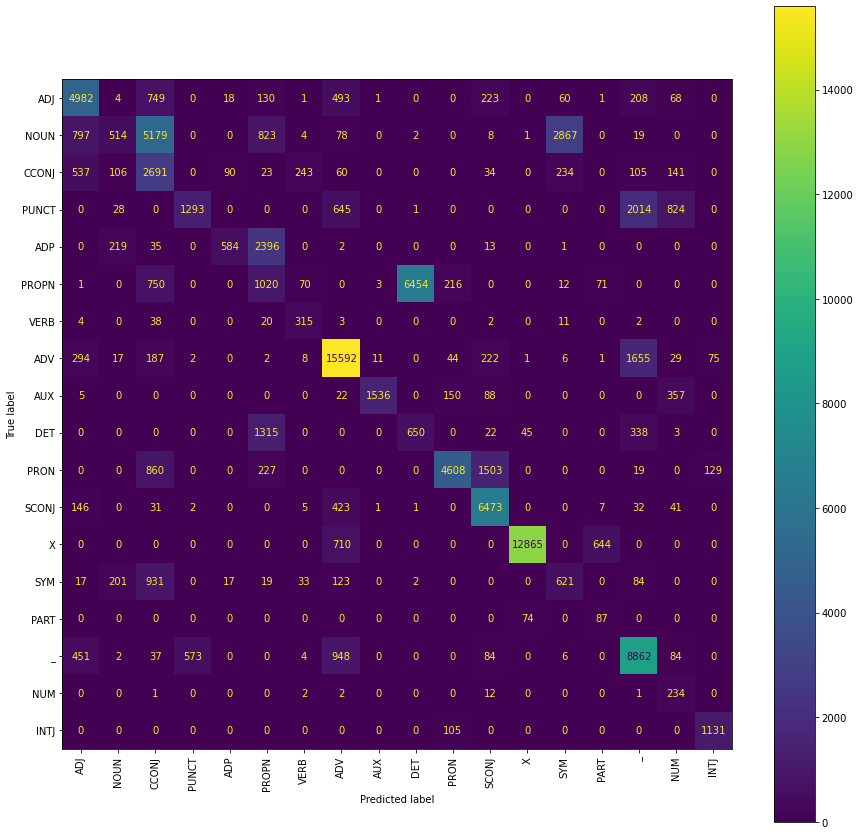

In [10]:
cm = confusion_matrix(flatten_gold_truth, flatten_predictions)

cmd = ConfusionMatrixDisplay(cm, display_labels=label_list)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

cmd.plot(xticks_rotation='vertical', ax =ax)

In [11]:
    
# For tasks requiring phrase-level annotation
# from seqeval.metrics import accuracy_score
# from seqeval.metrics import classification_report
# from seqeval.metrics import f1_score
# from seqeval.scheme import IOB1
# print('F1 Score is')
# print( f1_score(ground_truth, prediction) )

# print('Classification report')
# print( classification_report(ground_truth, prediction, scheme=IOB1) )

## Implement Rule-based System here

Let us write a simple rule to tag adverbs

In [12]:
def is_adverb(word):
    if word.endswith('ly'):
        return True
    else:
        return False

In [13]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        if is_adverb(word):
            prediction_sentence.append('ADV')
        else:
            if word in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [14]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.6873    0.7113    0.6991      6938
        NOUN     0.4711    0.0499    0.0903     10292
       CCONJ     0.2363    0.6503    0.3467      4264
       PUNCT     0.6914    0.2691    0.3874      4805
         ADP     0.9479    0.1791    0.3012      3250
       PROPN     0.1707    0.1186    0.1400      8597
        VERB     0.4599    0.7975    0.5833       395
         ADV     0.8159    0.8573    0.8361     18146
         AUX     0.9897    0.7118    0.8280      2158
         DET     0.0914    0.2739    0.1371      2373
        PRON     0.8995    0.6273    0.7391      7346
       SCONJ     0.7443    0.8986    0.8142      7162
           X     0.9907    0.9048    0.9458     14219
         SYM     0.1627    0.3032    0.2117      2048
        PART     0.1073    0.5404    0.1790       161
           _     0.6638    0.8000    0.7256     11051
         NUM     0.1309    0.9246    0.2293       252
        INTJ     0.8472    

# My Rule 1 is for VERB

Let us write a simple rule to tag verbs

In [28]:
def is_verb(word):
    if word.endswith('ed'):
        return True
    else:
        return False

In [29]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        if is_verb(word):
            prediction_sentence.append('VERB')
        else:
            if word in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [30]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.6894    0.6895    0.6895      6938
        NOUN     0.4711    0.0499    0.0903     10292
       CCONJ     0.2338    0.6297    0.3410      4264
       PUNCT     0.6914    0.2691    0.3874      4805
         ADP     0.8237    0.1797    0.2950      3250
       PROPN     0.1707    0.1186    0.1400      8597
        VERB     0.4599    0.7975    0.5833       395
         ADV     0.8165    0.8577    0.8366     18146
         AUX     0.9896    0.7067    0.8245      2158
         DET     0.0914    0.2739    0.1371      2373
        PRON     0.8995    0.6273    0.7391      7346
       SCONJ     0.7488    0.8970    0.8162      7162
           X     0.9907    0.9048    0.9458     14219
         SYM     0.1627    0.3032    0.2117      2048
        PART     0.1073    0.5404    0.1790       161
           _     0.6527    0.8148    0.7248     11051
         NUM     0.1314    0.9286    0.2302       252
        INTJ     0.8472    

# My Rule 2 is for Adjective

Let us write a simple rule to tag adjective

In [31]:
def is_adjective(word):
    if word.endswith('er'):
        return True
    else:
        return False

In [32]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        if is_adjective(word):
            prediction_sentence.append('ADJ')
        else:
            if word in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [33]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.5558    0.7433    0.6360      6938
        NOUN     0.4695    0.0486    0.0881     10292
       CCONJ     0.2234    0.5790    0.3224      4264
       PUNCT     0.6914    0.2691    0.3874      4805
         ADP     0.8433    0.1788    0.2950      3250
       PROPN     0.1688    0.1140    0.1361      8597
        VERB     0.4599    0.7975    0.5833       395
         ADV     0.8110    0.8238    0.8174     18146
         AUX     0.9897    0.7118    0.8280      2158
         DET     0.0914    0.2739    0.1371      2373
        PRON     0.8951    0.5950    0.7149      7346
       SCONJ     0.7384    0.8690    0.7984      7162
           X     0.9907    0.9048    0.9458     14219
         SYM     0.1614    0.2988    0.2096      2048
        PART     0.1073    0.5404    0.1790       161
           _     0.6661    0.7921    0.7237     11051
         NUM     0.1294    0.9127    0.2267       252
        INTJ     0.8472    

# My Rule 3 is for VERB

Let us write a simple rule to tag verbs

In [34]:
def is_verb(word):
    if word.endswith('ing'):
        return True
    else:
        return False

In [35]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        if is_verb(word):
            prediction_sentence.append('VERB')
        else:
            if word in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [36]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.6902    0.7057    0.6978      6938
        NOUN     0.4667    0.0491    0.0888     10292
       CCONJ     0.2342    0.6309    0.3415      4264
       PUNCT     0.6981    0.2681    0.3874      4805
         ADP     0.8237    0.1797    0.2950      3250
       PROPN     0.1707    0.1186    0.1400      8597
        VERB     0.4567    0.7873    0.5781       395
         ADV     0.8208    0.8359    0.8283     18146
         AUX     0.9897    0.7118    0.8280      2158
         DET     0.0914    0.2739    0.1371      2373
        PRON     0.8995    0.6273    0.7391      7346
       SCONJ     0.7444    0.8949    0.8127      7162
           X     0.9907    0.9048    0.9458     14219
         SYM     0.1642    0.3027    0.2129      2048
        PART     0.1073    0.5404    0.1790       161
           _     0.6375    0.8222    0.7181     11051
         NUM     0.1314    0.9286    0.2302       252
        INTJ     0.8472    

# My Rule 4 is for Adverbs

Let us write a simple rule to tag adverbs.
We consider question words as adverb.

In [69]:
def is_adverb(word):
    if word.startswith('wh'):
        return True
    else:
        return False

In [70]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        if is_adverb(word):
            prediction_sentence.append('ADV')
        else:
            if word in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [71]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.6886    0.7178    0.7029      6938
        NOUN     0.4711    0.0499    0.0903     10292
       CCONJ     0.2207    0.6320    0.3272      4264
       PUNCT     0.6914    0.2691    0.3874      4805
         ADP     0.8437    0.1794    0.2959      3250
       PROPN     0.1744    0.1171    0.1402      8597
        VERB     0.4599    0.7975    0.5833       395
         ADV     0.8188    0.8581    0.8380     18146
         AUX     0.9897    0.7118    0.8280      2158
         DET     0.0914    0.2739    0.1371      2373
        PRON     0.8966    0.5889    0.7109      7346
       SCONJ     0.7454    0.9038    0.8170      7162
           X     0.9907    0.9048    0.9458     14219
         SYM     0.1607    0.2988    0.2090      2048
        PART     0.1073    0.5404    0.1790       161
           _     0.6686    0.8012    0.7289     11051
         NUM     0.1314    0.9286    0.2302       252
        INTJ     0.8458    